In [1]:
import os

os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [2]:
import gc
import pickle
import sys

import librosa
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf
from audiomentations import AddGaussianNoise, Compose, PitchShift, Shift, TimeStretch
from IPython.lib.display import Audio
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    f1_score,
    precision_score,
    recall_score,
    roc_curve,
)
from sklearn.model_selection import train_test_split
from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras import backend as K
from tensorflow.keras.layers import (
    LSTM,
    Activation,
    BatchNormalization,
    Bidirectional,
    Conv1D,
    Dense,
    Dropout,
    Flatten,
    Input,
    MaxPool1D,
)
from tensorflow.keras.utils import to_categorical

2024-05-05 17:15:34.346068: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-05-05 17:15:34.372131: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-05 17:15:34.372156: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-05 17:15:34.372163: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-05-05 17:15:34.376468: I tensorflow/core/platform/cpu_feature_g

In [3]:
gpus = tf.config.list_physical_devices("GPU")
print(gpus)
tf.config.set_logical_device_configuration(
    gpus[0],
    [tf.config.LogicalDeviceConfiguration(memory_limit=8000)],
)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


2024-05-05 17:15:36.398448: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-05-05 17:15:36.414041: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-05-05 17:15:36.415605: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [4]:
emotion_list = {
    0: "neutral",
    1: "calm",
    2: "happy",
    3: "sad",
    4: "angry",
    5: "fearful",
    6: "disgusted",
    7: "surprised",
}
RAV = "data/ravdess-emotional-speech-audio/audio_speech_actors_01-24/"
dir_list = os.listdir(RAV)
paths = []
for dir in dir_list:
    files = os.listdir(RAV + dir)
    for file in files:
        paths.append(RAV + dir + "/" + file)

path_train, path_test = train_test_split(paths, test_size=0.2)

In [5]:
augment = Compose(
    [
        AddGaussianNoise(min_amplitude=0.001, max_amplitude=0.002, p=0.5),  # p = 0.5
        TimeStretch(min_rate=0.8, max_rate=1.25, p=0.5),
        PitchShift(min_semitones=-4, max_semitones=4, p=0.5),
        Shift(p=0.5),
    ]
)

In [6]:
def get_label(path, emotion_list):
    fileName = os.path.basename(path)
    parts = fileName.split(".")[0].split("-")
    return int(parts[2]) - 1


def process_test_audios(paths):
    batch_features, batch_labels = [], []
    for path in paths:
        audio, sample_rate = librosa.load(path)
        batch_features.append(audio)
        batch_labels.append(get_label(path, emotion_list))
    return batch_features, batch_labels


def audio_generator(file_paths, batch_size):
    while True:
        batch_paths = np.random.choice(a=file_paths, size=batch_size)
        batch_features, batch_labels = [], []

        for path in batch_paths:
            audio, sample_rate = librosa.load(path)
            augmented_audio = augment(samples=audio, sample_rate=sample_rate)
            batch_features.append(augmented_audio)
            batch_labels.append(get_label(path, emotion_list))

        yield batch_features, batch_labels


def extract_mfcc(audio):
    mfccs = np.mean(librosa.feature.mfcc(y=audio, sr=22050, n_mfcc=40).T, axis=0)
    return mfccs


def plot_network_history(network_history):
    fig, axes = plt.subplots(1, 2, figsize=(18, 6))
    axes[0].plot(network_history.history["loss"], label="Training Loss")
    axes[0].plot(network_history.history["val_loss"], label="Validation Loss")
    axes[0].set_xlabel("Epoch")
    axes[0].set_ylabel("Loss")
    axes[0].legend()

    axes[1].plot(network_history.history["categorical_accuracy"], label="Training Categorical Accuracy")
    axes[1].plot(network_history.history["val_categorical_accuracy"], label="Validation Categorical Accuracy")
    axes[1].set_xlabel("Epoch")
    axes[1].set_ylabel("Accuracy")
    axes[1].legend()
    plt.show()

In [7]:
# X_test, Y_test = process_test_audios(path_test)

# batch_size = 24
# gen = audio_generator(file_paths=path_train, batch_size=batch_size)
# X_train, Y_train = [], []
# for i in range(500):
#     batch_data, batch_labels = next(gen)
#     X_train += batch_data
#     Y_train += batch_labels


# Y_train, Y_test = to_categorical(Y_train), to_categorical(Y_test)
# len(X_train), len(Y_train)

In [8]:
# data = {"X_train_raw": X_train, "X_test_raw": X_test, "Y_train": Y_train, "Y_test": Y_test}
# with open("./data/raw_data.pickle", "wb") as f:
#     pickle.dump(data, f)

In [9]:
# with open("./data/raw_data.pickle", "rb") as f:
#     data = pickle.load(f)
# X_train = data["X_train_raw"]
# X_test = data["X_test_raw"]
# Y_train = data["Y_train"]
# Y_test = data["Y_test"]

In [10]:
# X_train = np.array([extract_mfcc(audio) for audio in X_train])
# X_test = np.array([extract_mfcc(audio) for audio in X_test])
# X_train = np.expand_dims(X_train, -1)
# X_test = np.expand_dims(X_test, -1)

In [11]:
# data = {"X_train": X_train, "X_test": X_test, "Y_train": Y_train, "Y_test": Y_test}
# with open("./data/processed_data.pickle", "wb") as f:
#     pickle.dump(data, f)

In [12]:
with open("./data/processed_data.pickle", "rb") as f:
    data = pickle.load(f)
X_train = data["X_train"]
X_test = data["X_test"]
Y_train = data["Y_train"]
Y_test = data["Y_test"]

In [13]:
X_train.shape

(12000, 40, 1)

In [14]:
print(gc.collect())
K.clear_session()

num_classes = len(Y_test[0])
model = Sequential()

layers = [
    Input(shape=(X_train.shape[1], X_train.shape[2])),
    LSTM(1024),
    Dense(num_classes, activation="softmax"),
]

model = tf.keras.Sequential(layers)
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["categorical_accuracy"])

model.summary()

51


2024-05-05 17:15:36.833362: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-05-05 17:15:36.833628: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-05-05 17:15:36.833749: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 1024)              4202496   
                                                                 
 dense (Dense)               (None, 8)                 8200      
                                                                 
Total params: 4210696 (16.06 MB)
Trainable params: 4210696 (16.06 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [15]:
es = keras.callbacks.EarlyStopping(
    monitor="val_categorical_accuracy", min_delta=0.00005, patience=10, restore_best_weights=True
)
lr_scheduler = keras.callbacks.ReduceLROnPlateau(
    monitor="val_categorical_accuracy",
    factor=0.5,
    patience=7,
    min_lr=1e-7,
    verbose=1,
)


network_history = model.fit(
    X_train,
    Y_train,
    epochs=100,
    batch_size=64,
    validation_split=0.2,
    callbacks=[es, lr_scheduler],
)

Epoch 1/100
  1/150 [..............................] - ETA: 3:26 - loss: 2.0851 - categorical_accuracy: 0.0312

2024-05-05 17:15:39.526991: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8800
2024-05-05 17:15:39.574398: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7e46094f5490 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-05-05 17:15:39.574428: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3060 Ti, Compute Capability 8.6
2024-05-05 17:15:39.579013: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-05-05 17:15:39.646751: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


150/150 [==============================] - 4s 18ms/step - loss: 1.9521 - categorical_accuracy: 0.2292 - val_loss: 1.8214 - val_categorical_accuracy: 0.2817 - lr: 0.0010
Epoch 2/100
150/150 [==============================] - 2s 15ms/step - loss: 1.8377 - categorical_accuracy: 0.2889 - val_loss: 1.7519 - val_categorical_accuracy: 0.3104 - lr: 0.0010
Epoch 3/100
150/150 [==============================] - 2s 15ms/step - loss: 1.7256 - categorical_accuracy: 0.3326 - val_loss: 1.6493 - val_categorical_accuracy: 0.3679 - lr: 0.0010
Epoch 4/100
150/150 [==============================] - 2s 15ms/step - loss: 1.6470 - categorical_accuracy: 0.3672 - val_loss: 1.6845 - val_categorical_accuracy: 0.3550 - lr: 0.0010
Epoch 5/100
150/150 [==============================] - 2s 15ms/step - loss: 1.5907 - categorical_accuracy: 0.3903 - val_loss: 1.5726 - val_categorical_accuracy: 0.4054 - lr: 0.0010
Epoch 6/100
150/150 [==============================] - 2s 15ms/step - loss: 1.5361 - categorical_accuracy: 

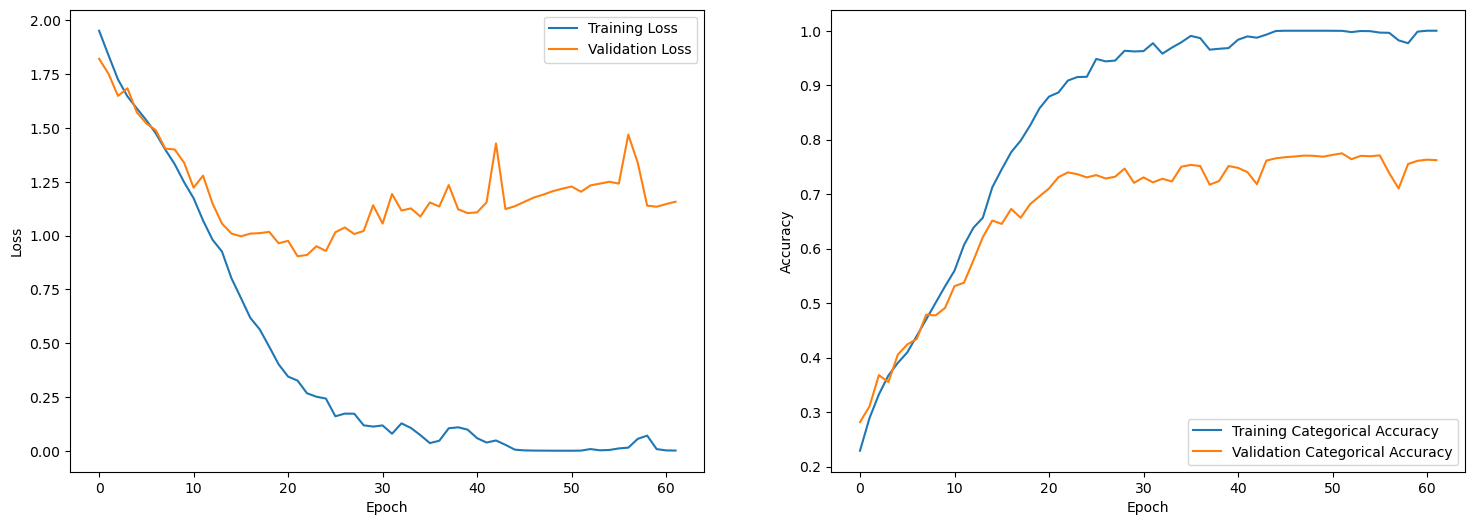

In [16]:
plot_network_history(network_history)

In [17]:
test_loss, test_acc = model.evaluate(X_test, Y_test)
preds = model.predict(X_test)

9/9 [==============================] - 0s 4ms/step


In [18]:
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, 1)
y_true = np.argmax(Y_test, 1)

print("Test accuracy: %g" % (accuracy_score(y_true, y_pred)))
print("Precision", precision_score(y_true, y_pred, average="macro"))
print("Recall", recall_score(y_true, y_pred, average="macro"))
print("f1_score", f1_score(y_true, y_pred, average="macro"))

9/9 [==============================] - 0s 4ms/step
Test accuracy: 0.569444
Precision 0.5571702676755869
Recall 0.5509019162425258
f1_score 0.5490115184060081


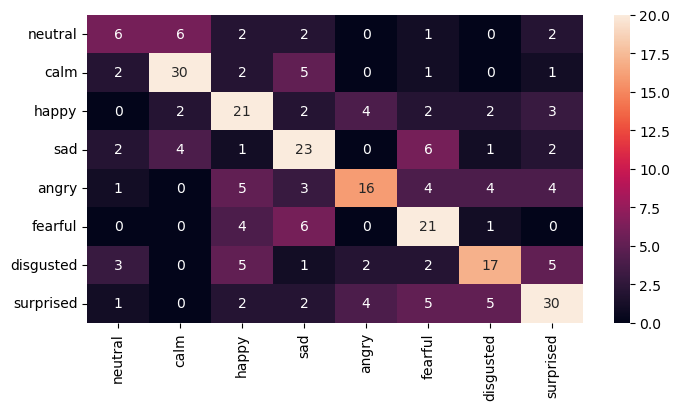

In [19]:
plt.figure(figsize=(8, 4))
conf = confusion_matrix(y_true, y_pred)
labels = emotion_list.values()
sns.heatmap(conf, annot=True, fmt="d", vmax=20, xticklabels=labels, yticklabels=labels)
plt.show()